# Detecting Political Bias with an RNN

## Setup

In [53]:
import pathlib
import os
import math, random

import numpy as np
import tensorflow as tf
from tensorflow.keras import utils

from tensorflow.keras import preprocessing

tf.__version__


'2.3.0'

Import `matplotlib` and create a helper function to plot graphs:

In [54]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])

## Setup input pipeline




In [55]:
cwd = os.getcwd()
train_dir = pathlib.Path(cwd).parent.parent/'Data'/'Train'
test_dir = pathlib.Path(cwd).parent.parent/'Data'/'Test'

print(train_dir)
print(test_dir)





/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/Train
/Users/muhammadrafay/Desktop/UIUC/Fall2020/CS410_Text_Information_Systems/Final Project/Political_Bias_NLP/Data/Test


In [56]:

train_split = 0.7


cwd = os.getcwd()

labeled_left_dir = pathlib.Path.joinpath(dataset_dir.parent, "Labeled_Data/Left/Left.txt")
labeled_right_dir = pathlib.Path.joinpath(dataset_dir.parent, "Labeled_Data/Right/Right.txt")

Train_left_dir = pathlib.Path.joinpath(dataset_dir.parent, "Train/Left")
Train_right_dir = pathlib.Path.joinpath(dataset_dir.parent, "Train/Right")

Test_left_dir = pathlib.Path.joinpath(dataset_dir.parent, "Test/Left")
Test_right_dir = pathlib.Path.joinpath(dataset_dir.parent, "Test/Right")

labeled_dirs = [labeled_left_dir, labeled_right_dir]
train_dirs = [Train_left_dir, Train_right_dir]
test_dirs = [Test_left_dir, Test_right_dir]


for dr in range(2):

    f = open(labeled_dirs[dr], "r")
    lines = f.readlines()

    
    arr = np.arange(0,len(lines))
    np.random.shuffle(arr)
    
    nTrain = math.floor(len(lines)*train_split)
    
    
    c = 0  
    for i in range(nTrain):
        c = c + 1                                   
        file_path = pathlib.Path.joinpath(train_dirs[dr], str(c) + '.txt')                                    
        nf = open(file_path, "w")
        nf.write(lines[arr[i]])
    
    c = 0
    for i in range(nTrain, len(lines)):
        c = c + 1                                   
        file_path = pathlib.Path.joinpath(test_dirs[dr], str(c) + '.txt')                                    
        nf = open(file_path, "w")
        nf.write(lines[arr[i]])




In [57]:
batch_size = 16
seed = 42


raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    seed=seed)

raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    seed=seed)


Found 404 files belonging to 2 classes.
Found 175 files belonging to 2 classes.


In [58]:
for text_batch, label_batch in raw_train_ds.take(2):
    for i in range(10):
        print("Question: ", text_batch.numpy()[i][:100], '...')
        print("Label:", label_batch.numpy()[i])

Question:  b'What Does It Mean to Be a Republican?\n' ...
Label: 1
Question:  b'Are Democrats Wasting Their Time Taking On the Electoral College?\n' ...
Label: 0
Question:  b'Democratic lawmakers launch blast at inspectors general in Clinton email probe\n' ...
Label: 0
Question:  b'Who Will Republican Voters Blame for the Failure of the GOP Health-Care Bill?\n' ...
Label: 1
Question:  b'Republicans angling for posh ambassadorships, RNC chair\n' ...
Label: 1
Question:  b'Nevada Democratic Convention becomes \xe2\x80\x99unruly and unpredictable\xe2\x80\x99 amid rules disputes over delegat' ...
Label: 0
Question:  b'The Democrats fighting the legal battles against Trump\n' ...
Label: 0
Question:  b'Democrats review Clinton\xe2\x80\x99s convention message \n' ...
Label: 0
Question:  b'The Art of the Republican National Convention\n' ...
Label: 1
Question:  b'Lynch, Justice opposed Comey\xe2\x80\x99s Clinton email letter; Democrats in Senate demand answers\n' ...
Label: 0
Question:  b'Repub

In [59]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Left
Label 1 corresponds to Right


Initially this returns a dataset of (text, label pairs):

In [60]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'Lynch, Justice opposed Comey\xe2\x80\x99s Clinton email letter; Democrats in Senate demand answers\n'
 b'title\n' b'The Democrats fighting the legal battles against Trump\n'
 b'CIA report of Russia interference in 2016 race divides Republicans\n'
 b'Republicans Rally Around Paul Ryan\n'
 b'White House sees Democrats lining up on Iran\n'
 b'Can this Democrat really beat Hillary Clinton?\n'
 b'How James Comey Hurt the FBI\xe2\x80\x94and the Democratic Process\n'
 b'Bernie Sanders \xe2\x80\x99humiliated\xe2\x80\x99 Democrats can\xe2\x80\x99t talk to \xe2\x80\x99white working class\xe2\x80\x99 voters\n'
 b'Pennsylvania Democrat Chaka Fattah Found Guilty \n'
 b'Why Won\xe2\x80\x99t More Republicans Privately Voting for Clinton Say So in Public?\n'
 b'Watching the Benghazi Film, 13 Hours, With a Republican Crowd\n'
 b'A message for my fellow Republicans: If you back Trump you will not be trusted again\n'
 b'9/11 record of Republican \xe2\x80\x99faithless elector\xe2\x80\x99 called 

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [61]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [62]:
train_dataset = raw_train_ds
test_dataset =  raw_test_ds
#train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [63]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'The Feedback Loop of Doom for Democratic Norms\n'
 b'Democrats protest Trump\xe2\x80\x99s travel ban outside Supreme Court\n'
 b'Can this Democrat really beat Hillary Clinton?\n']

labels:  [0 0 0]


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [64]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [65]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'republicans', 'to', 'democrats', 'democratic',
       'republican', 'trump', 'on', 'for', 'in', 'clinton', 'a', 'of',
       'convention', 'house', 'and', 'democrat', 'is'], dtype='<U16')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [66]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   2,  995,  837,   14, 1042,   10,    6,  783,    0,    0,    0,
           0,    0],
       [   5,  301,   26,  566, 1184,  766,  268,  410,    0,    0,    0,
           0,    0],
       [  34,   95,   18,   74, 1179,   42,   12,    0,    0,    0,    0,
           0,    0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [67]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The Feedback Loop of Doom for Democratic Norms\n'
Round-trip:  the feedback loop of doom for democratic norms     

Original:  b'Democrats protest Trump\xe2\x80\x99s travel ban outside Supreme Court\n'
Round-trip:  democrats protest trump’s travel ban outside supreme court     

Original:  b'Can this Democrat really beat Hillary Clinton?\n'
Round-trip:  can this democrat really beat hillary clinton      



## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [68]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [69]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [70]:
# predict on a sample text without padding.

sample_text = ('Republicans lack agreement on Obamacare ahead of Trump speech')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00817871]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [71]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00817871]


Compile the Keras model to configure the training process:

In [72]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [73]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, #testdataset required
                    validation_steps=10)

Epoch 1/10
26/26 [==============================] - 2s 89ms/step - loss: 0.6929 - accuracy: 0.5074 - val_loss: 0.6916 - val_accuracy: 0.5063
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: 0.6901 - accuracy: 0.5074 - val_loss: 0.6897 - val_accuracy: 0.5125
Epoch 3/10
26/26 [==============================] - 0s 13ms/step - loss: 0.6863 - accuracy: 0.5074 - val_loss: 0.6861 - val_accuracy: 0.5125
Epoch 4/10
26/26 [==============================] - 0s 13ms/step - loss: 0.6799 - accuracy: 0.5074 - val_loss: 0.6790 - val_accuracy: 0.5125
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 0.6683 - accuracy: 0.5074 - val_loss: 0.6680 - val_accuracy: 0.5063
Epoch 6/10
26/26 [==============================] - 0s 13ms/step - loss: 0.6462 - accuracy: 0.5074 - val_loss: 0.6481 - val_accuracy: 0.4938
Epoch 7/10
26/26 [==============================] - 0s 14ms/step - loss: 0.6013 - accuracy: 0.5074 - val_loss: 0.5990 - val_accuracy: 0.5125
Epoch 8/10
26

In [74]:
test_loss, test_acc = model.evaluate(train_dataset) # test_dataset required

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

26/26 [==============================] - 0s 8ms/step - loss: 0.1269 - accuracy: 0.9827
Test Loss: 0.12694332003593445
Test Accuracy: 0.9826732873916626


(0.0, 0.7178374208509922)

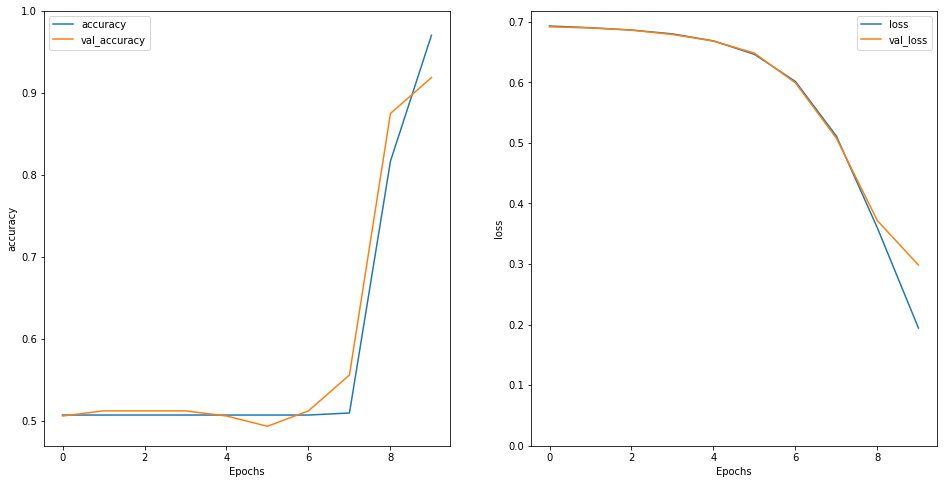

In [75]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [76]:
# predict on a sample text without padding.

sample_text1 = ('White House, Congress Republicans nearing key tax overhaul decisions')
sample_text2 = ('Democrats Hope Sunday Obamacare Rallies Can Help Them Regain Momentum ')

predictions = model.predict(np.array([sample_text1, sample_text2]))
print(predictions)

[[ 1.0248266]
 [-0.7582209]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.ipynb)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [77]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [78]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [79]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
26/26 [==============================] - 5s 188ms/step - loss: 0.6924 - accuracy: 0.5074 - val_loss: 0.6915 - val_accuracy: 0.5086
Epoch 2/10
26/26 [==============================] - 1s 25ms/step - loss: 0.6897 - accuracy: 0.5074
Epoch 3/10
26/26 [==============================] - 1s 23ms/step - loss: 0.6855 - accuracy: 0.5074
Epoch 4/10
26/26 [==============================] - 1s 27ms/step - loss: 0.6746 - accuracy: 0.5074
Epoch 5/10
26/26 [==============================] - 1s 20ms/step - loss: 0.6514 - accuracy: 0.5074
Epoch 6/10
26/26 [==============================] - 1s 20ms/step - loss: 0.5977 - accuracy: 0.5594
Epoch 7/10
26/26 [==============================] - 0s 19ms/step - loss: 0.4915 - accuracy: 0.8614
Epoch 8/10
26/26 [==============================] - 1s 19ms/step - loss: 0.3338 - accuracy: 0.9629
Epoch 9/10
26/26 [==============================] - 0s 19ms/step - loss: 0.1829 - accuracy: 0.9752
Epoch 10/10
26/26 [==============================] - 1s 20ms/step 

In [80]:
test_loss, test_acc = model.evaluate(train_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

26/26 [==============================] - 0s 5ms/step - loss: 0.0711 - accuracy: 0.9802
Test Loss: 0.07110126316547394
Test Accuracy: 0.9801980257034302


In [81]:
# predict on a sample text without padding.

sample_text1 = ('White House, Congress Republicans nearing key tax overhaul decisions')
sample_text2 = ('Democrats Hope Sunday Obamacare Rallies Can Help Them Regain Momentum ')

predictions = model.predict(np.array([sample_text1, sample_text2]))
print(predictions)

[[ 0.9013078]
 [-3.6422565]]


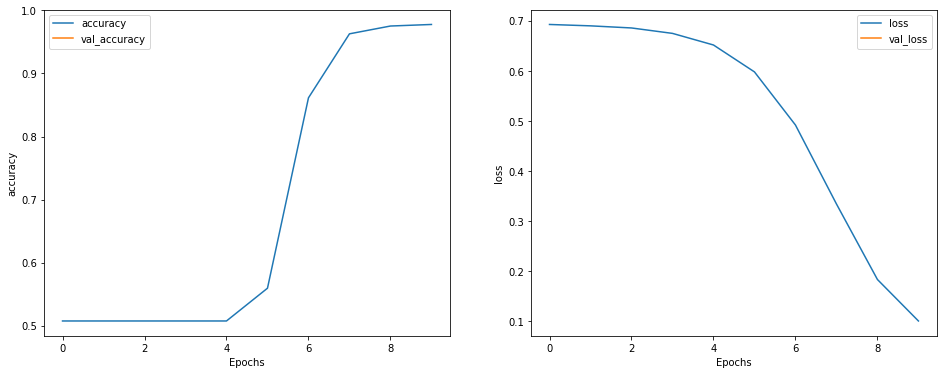

In [82]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
